In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [15]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [25]:
# Verify tables and structure from SQLite database
inspector = inspect(engine)
tbl_names = inspector.get_table_names()
i =1 
for table in tbl_names:
    print("Table "+str(i)+": "+str(table))
    i = i+1
    columns = inspector.get_columns(table)
    for col in columns:
        print("     Col: "+str(col["name"])+" ("+str(col["type"])+")")

Table 1: measurement
     Col: id (INTEGER)
     Col: station (TEXT)
     Col: date (TEXT)
     Col: prcp (FLOAT)
     Col: tobs (FLOAT)
Table 2: station
     Col: id (INTEGER)
     Col: station (TEXT)
     Col: name (TEXT)
     Col: latitude (FLOAT)
     Col: longitude (FLOAT)
     Col: elevation (FLOAT)


# Exploratory Climate Analysis

In [56]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#Precipitation data frame
prcp_df = pd.read_sql("SELECT date, prcp FROM Measurement", conn)
prcp_df.head()

#converting date from string to date/time
prcp_df["date"] = pd.to_datetime(prcp_df["date"],format="%Y-%m-%d", errors="coerce")
prcp_df

# Calculate the date 1 year ago from the last data point in the database
# Determining the max date and subtracting 365 days
max_date = prcp_df["date"].max().date()
today = dt.date.today()
min_date = (max_date - dt.timedelta(days=365))
print("Date Range: "+str(min_date)+" to "+str(max_date))

# Save the query results as a Pandas DataFrame and set the index to the date column, sort by date
year_prcp_df = prcp_df.loc[prcp_df["date"]>=min_date]
year_prcp_df = year_prcp_df.dropna()
year_prcp_df.set_index("date")
year_prcp_df.head()

Date Range: 2016-08-23 to 2017-08-23


C:\Users\madel\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.


,date,prcp
2363,2016-08-23,0.00
2364,2016-08-24,0.08
2365,2016-08-25,0.08
2366,2016-08-26,0.00
2367,2016-08-27,0.00


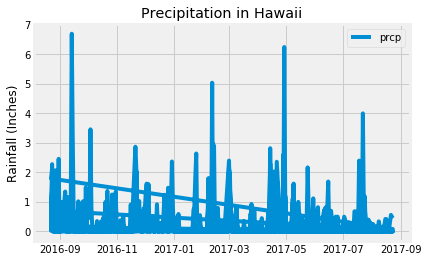

In [57]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.plot(year_prcp_df['date'], year_prcp_df['prcp'])
plt.title("Precipitation in Hawaii")
plt.ylabel('Rainfall (Inches)')
plt.legend()

plt.savefig("prcp_analysis.png")

In [58]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [60]:
# Design a query to show how many stations are available in this dataset?

stations_count = engine.execute("SELECT count(*) FROM Station")
for record in stations_count:
    print(record)

(9,)


In [69]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = engine.execute("SELECT station, COUNT(station) AS 'Count' FROM measurement GROUP BY station ORDER BY Count DESC")
for record in active_stations:
    print(record)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [73]:
#Highest number of observations
most_active = engine.execute("SELECT station, COUNT(station) AS 'Count' FROM measurement GROUP BY station ORDER BY Count DESC LIMIT 1")
for record in most_active:
    print(record)
    
data = pd.read_sql("SELECT * FROM Census_Data", conn)

('USC00519281', 2772)


In [80]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active_station = session.query(Measurement.station, 
                                    func.count(Measurement.station).label('count')).\
                                    group_by(Measurement.station).\
                                    order_by('count DESC').limit(1)[0][0]
                                    
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
                
session.query(*sel).filter(Measurement.station==most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

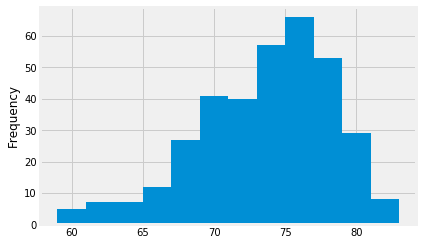

In [82]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_tobs = session.query(Measurement.tobs).\
                                filter(Measurement.station==most_active_station).\
                                filter(Measurement.date >= min_date).\
                                order_by(Measurement.date.desc()).all()

x = [x[0] for x in most_active_tobs]

plt.hist(x, bins=12)
plt.ylabel('Frequency')
plt.show()